# Run QPO simulations for multiple observations, fit simultaneously

Below we perform the same analysis as in the qpo_sims.py code, but with simultaneous fitting for multiple observations, which is applicable for the July/August 2022 data for 1ES 1927+654 because we have 4 short observations in the span of a week. For this, we use the broadband noise models that have been fit simultaneously (at the end of broadband.ipynb), with all of the parameters tied across all observations. To simulate the light curves, we have simulate one light curve per observation, matching each observation's observed properties. 

In [1]:
# load packages
import numpy as np 
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.integrate as integ
import scipy.fft
import os
import astropy.stats as st
from astropy import units as u
from astropy import constants as const
from astropy.io import fits
from astropy.time import Time
from astropy.coordinates import SkyCoord
import pandas as pd
from matplotlib.ticker import ScalarFormatter, FormatStrFormatter, NullFormatter
from matplotlib import ticker
import json
import glob
# from redshift get d_L
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=70 * u.km / u.s / u.Mpc, Om0=0.3)
# emcee stuff
import multiprocessing as mp
# from multiprocessing import Pool
import emcee
import corner
from scipy.stats import spearmanr, linregress, binned_statistic, chi2
import pylag
from joblib import Parallel, delayed

from timing import *

# set up plotting defaults
plt.rc('font', family='sans')
params = {
   'axes.labelsize': 45,
   'axes.linewidth': 3,
   'legend.fontsize': 30,
   'legend.frameon': True,
   'legend.fancybox': False,
   'legend.framealpha': 0.8,
   'legend.edgecolor': 'k',
   'lines.linewidth': 2,
   'font.size': 40,
   'font.weight': 'normal',
   'xtick.direction': 'in',
   'xtick.labelsize': 35,
   'xtick.color':'k',
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 18,
   'xtick.major.width': 2,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 10,
   'xtick.minor.size': 9,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 2,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 35,
   'ytick.left': True,
   'ytick.right': True,
   'ytick.major.pad': 10,
   'ytick.major.size': 18,
   'ytick.major.width': 2,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 9,
   'ytick.minor.visible': True,
   'ytick.minor.width': 2,
   'text.usetex': False,
   'figure.figsize': [10,10],
   'savefig.dpi': 500,
   }
plt.rcParams.update(params)

fig_path = '../figures/'
data_path = '../data/lightcurves/'
mcmc_path = 'broadband_mcmcs/'

/Users/megan/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## Set up Bayesian priors and likelihood functions, use MCMC function from broadband.ipynb

In [2]:
def log_prior(theta, model):
    if model == 'powerlaw':
        N0, b, c = theta
        if 0 < N0 < 1e10 and -5 < b < 5 and 0 < c < 100:
            return 0.0
    elif model == 'lorentzian':
        R, delta, c = theta
        if 0 < R < 1e2 and 1e-10 < delta < 1e1 and 1e-10 < c < 100:
            return 0.0
    return -np.inf

def log_likelihood_multi(theta, fs, ys, model):
    """
    Compute the total log likelihood over multiple datasets.

    :param theta: Model parameters.
    :param fs: List of arrays, each containing frequency values for a dataset.
    :param ys: List of arrays, each containing power values for a dataset.
    :param model: The model to use ('powerlaw', 'broken_powerlaw', or 'lorentzian').
    :return: Total log likelihood summed over all datasets.
    """
    total_log_likelihood = 0.0
    for f, y in zip(fs, ys):
        if model == 'powerlaw':
            N0, b, c = theta
            model_y = powerlaw(f, N0, b, c)
        elif model == 'lorentzian':
            R, delta, c = theta
            model_y = lorentzian(f, R, delta, c)
        total_log_likelihood += np.sum((y / model_y) + np.log(model_y))
    return total_log_likelihood  # note that this is really the negative log likelihood (i.e. maximize this fn for MLE)

def log_probability_multi(theta, fs, ys, model):
    lp = log_prior(theta, model)
    if not np.isfinite(lp):
        return -np.inf
    return lp - log_likelihood_multi(theta, fs, ys, model)

In [3]:
def MLE_and_MCMC_multi(name, obs, data_path, emin, emax, tbin=20, n=0, nwalkers=32, use_model='all', nsteps=5500, nburn=500):

    # first grab the data and create lists of frequencies and powers
    # still need the unbinned data for fitting
    freq = []
    power = []
    f_min = []
    f_max = []
    for i,obsid in enumerate(obs):
        _, _, _, freq_tmp, power_tmp, _, _, f_min_tmp, f_max_tmp, _, _ = make_psd(obsid, data_path, emin, emax, tbin, n=0)
        freq.append(freq_tmp)
        power.append(power_tmp)
        f_min.append(f_min_tmp)
        f_max.append(f_max_tmp)
    min_f = min(f_min)
    max_f = max(f_max)
    grid = np.linspace(min_f, max_f, 1000)

    # first maximize likelihood - power law
    if use_model == 'powerlaw' or use_model == 'all':
        ndim_pl = 3
        initial_guess_pl = [1e-4, 2, 1]
        result_pl = opt.minimize(log_likelihood_multi, initial_guess_pl, args=(freq, power, 'powerlaw'),
                                bounds=((1e-8,1e4),(-2,2),(1e-2,1e2)))
        maxlike_pl = result_pl.x
        p0_pl = maxlike_pl * (1 + 1e-3 * np.random.randn(nwalkers, ndim_pl))

    # first maximize likelihood - lorentzian
    if use_model == 'lorentzian' or use_model == 'all':
        ndim_lor = 3
        initial_guess_lor = [5e-1, 1e-3, 1]
        result_lor = opt.minimize(log_likelihood_multi, initial_guess_lor, args=(freq, power, 'lorentzian'),
                                  bounds=((0,100),(1e-6,1),(1e-4,100)))
        maxlike_lor = result_lor.x
        p0_lor = maxlike_lor * (1 + 1e-3 * np.random.randn(nwalkers, ndim_lor))

    # plot each of the observations
    if use_model == 'all':

        fig, axs = plt.subplots(figsize=(15*len(obs),22), nrows=3, ncols=len(obs), gridspec_kw={'hspace':0, 'height_ratios':[1,0.3,0.3]})

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]
            fmin = f_min[j]
            fmax = f_max[j]

            ax = axs[0,j]
            ax.step(f, p, color='k', lw=2, where='mid')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(8e-2,3e2)
            ax = axs[1,j]
            ax.axhline(1, color='xkcd:peach', ls='--', lw=5)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('D / M')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(3e-2,2e1)
            ax = axs[2,j]
            ax.axhline(1, color='slateblue', ls='--', lw=5)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('D / M')
            ax.set_xlabel('Frequency [Hz]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(3e-2,2e1)

    if use_model == 'powerlaw' or use_model == 'lorentzian':

        if use_model == 'powerlaw':
            use_color = 'xkcd:peach'
        if use_model == 'lorentzian':
            use_color = 'slateblue'

        fig, axs = plt.subplots(figsize=(15*len(obs),14), nrows=2, ncols=len(obs), gridspec_kw={'hspace':0, 'height_ratios':[1,0.3]})

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]
            fmin = f_min[j]
            fmax = f_max[j]

            ax = axs[0,j]
            ax.step(f, p, color='k', lw=2, where='mid')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(8e-2,3e2)
            ax = axs[1,j]
            ax.axhline(1, color=use_color, ls='--', lw=5)
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_ylabel('D / M')
            ax.set_xlabel('Frequency [Hz]')
            ax.set_xlim(fmin, fmax)
            ax.set_ylim(3e-2,2e1)

    # grab n_rand samples and pick out the median fit
    n_rand = 100
    if use_model == 'powerlaw' or use_model == 'all':

        fname = mcmc_path+'broadband_'+name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_powerlaw.h5'
        backend = emcee.backends.HDFBackend(fname)

        # if we have run the MCMC, load it in
        if os.path.exists(fname):
            samples_pl = backend.get_chain(discard=nburn, flat=True)
        # if we haven't run the MCMC yet, run it
        else:
            backend.reset(nwalkers, ndim_pl)
            sampler_pl = emcee.EnsembleSampler(nwalkers, ndim_pl, log_probability_multi, args=(freq, power, 'powerlaw'), backend=backend)
            sampler_pl.run_mcmc(p0_pl, nsteps, progress=True)
            samples_pl = sampler_pl.get_chain(discard=nburn, flat=True)

        lab = [r"$\log N_0$", r"$\alpha$", r"$c$"]
        fig = corner.corner(samples_pl, labels=lab, truths=maxlike_pl, figsize=(18,18), labelpad=1)

        Rhat_max_pl = []
        QPO_freq_pl = []
        SSE_pl_tot = 0

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]

            fit_pl = np.zeros((len(grid),n_rand))
            fit_binned_pl = np.zeros((len(f),n_rand))
            for i in range(n_rand):

                use_N0, use_b, use_c = samples_pl[i,:]
                fit_pl[:,i] = powerlaw(grid, use_N0, use_b, use_c)
                fit_binned_pl[:,i] = powerlaw(f, use_N0, use_b, use_c)

            med_fit_pl = np.median(fit_pl, axis=1)
            med_fit_binned_pl = np.median(fit_binned_pl, axis=1)
            axs[0,j].plot(grid, med_fit_pl, color='xkcd:peach', lw=5, ls='--', label='Power-Law (MCMC)')
            axs[1,j].step(f, p / med_fit_binned_pl, color='k', lw=2, where='mid')

            # find T_R
            Rhat_pl = 2 * p / med_fit_binned_pl #null(bin_midpoints, *popt_null)
            Rhat_max_pl.append(np.max(Rhat_pl))
            QPO_freq_pl.append(f[np.argmax(Rhat_pl)])

            # find T_SSE
            SSE_pl = np.sum(((p - med_fit_binned_pl) / med_fit_binned_pl)**2)
            SSE_pl_tot += SSE_pl

        print('R (power-law): ', Rhat_max_pl)
        print('QPO freq. (power-law): ', QPO_freq_pl)
        print('SSE (power-law): ', SSE_pl_tot)

    if use_model == 'lorentzian' or use_model == 'all':

        fname = mcmc_path+'broadband_'+name+'_'+str(emin)+'-'+str(emax)+'keV_mcmc_lorentzian.h5'
        backend = emcee.backends.HDFBackend(fname)

        # if we have run the MCMC, load it in
        if os.path.exists(fname):
            samples_lor = backend.get_chain(discard=nburn, flat=True)
        # if we haven't run the MCMC yet, run it
        else:
            backend.reset(nwalkers, ndim_lor)
            sampler_lor = emcee.EnsembleSampler(nwalkers, ndim_lor, log_probability_multi, args=(freq, power, 'lorentzian'), backend=backend)
            sampler_lor.run_mcmc(p0_lor, nsteps, progress=True)
            samples_lor = sampler_lor.get_chain(discard=nburn, flat=True)

        lab = [r"$R$", r"$\Delta$", r"$c$"]
        fig = corner.corner(samples_lor, labels=lab, truths=maxlike_lor, figsize=(18,18), labelpad=1)

        Rhat_max_lor = []
        QPO_freq_lor = []
        SSE_lor_tot = 0

        for j in range(len(freq)):
            f = freq[j]
            p = power[j]

            fit_lor = np.zeros((len(grid),n_rand))
            fit_binned_lor = np.zeros((len(f),n_rand))
            for i in range(n_rand):
                use_R, use_delta, use_c = samples_lor[i,:]
                fit_lor[:,i] = lorentzian(grid, use_R, use_delta, use_c)
                fit_binned_lor[:,i] = lorentzian(f, use_R, use_delta, use_c)
            med_fit_lor = np.median(fit_lor, axis=1)
            med_fit_binned_lor = np.median(fit_binned_lor, axis=1)
            axs[0,j].plot(grid, med_fit_lor, color='slateblue', lw=5, ls='--', label='Lorentzian (MCMC)')
            if use_model == 'all':
                axs[2,j].step(f, p / med_fit_binned_lor, color='k', lw=2, where='mid')
            else:
                axs[1,j].step(f, p / med_fit_binned_lor, color='k', lw=2, where='mid')

            # find T_R
            Rhat_lor = 2 * p / med_fit_binned_lor 
            Rhat_max_lor.append(np.max(Rhat_lor))
            QPO_freq_lor.append(f[np.argmax(Rhat_lor)])

            # find T_SSE
            SSE_lor = np.sum(((p - med_fit_binned_lor) / med_fit_binned_lor)**2)
            SSE_lor_tot += SSE_lor

        print('R (lorentzian): ', Rhat_max_lor)
        print('QPO freq. (lorentzian): ', QPO_freq_lor)
        print('SSE (lorentzian): ', SSE_lor_tot)

    axs[0,0].legend(fontsize=24, loc='lower left')

    # for LRT + saving all the samples
    if use_model == 'all':

        # power law values to save
        save_N0_pl = samples_pl[:,0]
        save_b_pl = samples_pl[:,1]
        save_c_pl = samples_pl[:,2]

        # lorentzian values to save
        save_R_lor = samples_lor[:,0]
        save_delta_lor = samples_lor[:,1]
        save_c_lor = samples_lor[:,2]

        return save_N0_pl, save_b_pl, save_c_pl, Rhat_max_pl, QPO_freq_pl, SSE_pl_tot, save_R_lor, save_delta_lor, save_c_lor, Rhat_max_lor, QPO_freq_lor, SSE_lor_tot
    
    elif use_model == 'powerlaw':
        return Rhat_max_pl, QPO_freq_pl, SSE_pl_tot
    elif use_model == 'lorentzian':
        return Rhat_max_lor, QPO_freq_lor, SSE_lor_tot

## Set up getting key values from the light curve

In [4]:
def get_key_values(obs, data_path, emin, emax, tbin=20):

    lc_file = "PN_"+obs+"_"+str(emin)+"-"+str(emax)+"_"+str(tbin)+"s.lc"
    hdu = fits.open(data_path+lc_file)
    data = hdu[1].data
    data = data[~np.isnan(data['RATE'])]
    time = data['TIME']-data['TIME'][0]
    rate = data['RATE']
    err = data['ERROR']

    N = len(time)
    mean = np.mean(rate)
    rms = np.sqrt(np.sum((rate - mean)**2) / (N - 1))

    return N, mean, rms

## Timmer & Koenig (1995) simulations

The two cells below are the same functions as are used in qpo_sims.py to fit individual observations. Things will change when we go to run fit_TK; this is where we will account for the fact that we actually have 4 observations per simulation.

In [5]:
def timmerkonig_sims(duration, tbin, psd_model, psd_params, mean_obs, rms_obs, sim_index, plot=False):

    # number of samples
    N = int(duration / tbin)

    # frequency array
    all_freqs = np.fft.fftfreq(N, d=tbin)
    pos_freqs = all_freqs[all_freqs > 0] # exclude 0

    # compute gaussian distributed random numbers for the real and imaginary parts of the phase
    np.random.seed(seed = np.random.randint(0,10000) + sim_index)
    rand_re = np.random.normal(size=pos_freqs.shape)
    rand_im = np.random.normal(size=pos_freqs.shape)
    rand_im[-1] = 0 # nyquist freq is real
    sim_spec = rand_re + 1j * rand_im
    if psd_model == 'powerlaw':
        psd_shape = powerlaw(pos_freqs, psd_params[0], psd_params[1], psd_params[2])
    elif psd_model == 'lorentzian':
        psd_shape = lorentzian(pos_freqs, psd_params[0], psd_params[1], psd_params[2])
    sim_spec = sim_spec * np.sqrt(0.5 * psd_shape) # for a more general power spectrum
    sim_spec[0] = 0 + 0j

    # add in the negative frequencies 
    sim_spec_neg = np.conj(sim_spec[1:-1]) # ignore the 0 freq and the nyquist frequency
    sim_spec_neg = sim_spec_neg[::-1] # reverse the order
    full_spec = np.concatenate([sim_spec, sim_spec_neg])

    # inverse FFT to get the time series
    light_curve = np.fft.irfft(full_spec, n=N)

    # scale to the observations - grab the mean and RMS from simulated light curves
    mean_sim = np.mean(light_curve)
    rms_sim = np.sqrt(np.sum((light_curve - mean_sim)**2) / (N - 1))
    light_curve = light_curve - mean_sim # scale mean to 0
    light_curve = light_curve * rms_obs / rms_sim # scale the rms to what we observe
    light_curve = light_curve + mean_obs # scale to the observed mean
    light_curve[light_curve < 0] = 0 # remove unphysical data points with ct rate < 0

    # times for plotting
    times = np.arange(0,duration,tbin)

    if plot:

        fig, ax = plt.subplots(figsize=(18,10))
        ax.plot(times, light_curve, 'k-')
        ax.set_xlabel('Time [s]')
        ax.set_ylabel('Rate [cps]')

    return light_curve

In [6]:
def make_TK_psd(lc, tbin, psd_model, psd_params, n=0, plot=False):

    # length of the light curve will help with duration
    N_tot = len(lc)
    duration = N_tot * tbin

    # time array
    lc_time = np.arange(0, duration, tbin)

    # poisson noise
    lc_err = np.sqrt(lc * tbin)
    lc_err[lc == 0] = np.median(lc_err)

    # maximum frequency that can be probed = nyquist = 1 / (2 * tbin)
    f_max = 1 / (2 * tbin)
    # minimimum frequency that can be probed = 1 / T_obs
    T_obs = max(lc_time)
    f_min = 1 / T_obs
    lc = pylag.LightCurve(t=lc_time, r=lc, e=lc_err, interp_gaps=True) # there shouldn't be any gaps though
    per = pylag.Periodogram(lc)

    x = per.freq
    y = per.periodogram
    # remove the 0 frequency
    x = x[1:]
    y = y[1:]

    if n == 0:
        # there will be no error bars on the data
        freq, power = x, y

    else:
        # bin the data
        mean_bin_edges, mean_bin_values = bin_fft_data(x, y, n, 'mean')
        std_bin_edges, std_bin_values = bin_fft_data(x, y, n, 'std') / np.sqrt(n)
        bin_midpoints = 0.5 * (mean_bin_edges[1:] + mean_bin_edges[:-1])
        bin_widths = 0.5 * (mean_bin_edges[1:] - mean_bin_edges[:-1])
        freq, power, freq_err, power_err = bin_midpoints, mean_bin_values, bin_widths, std_bin_values

    if plot:

        # plot the power spectrum, and compare to the input
        fig, ax = plt.subplots(figsize=(14,10))
        if n == 0:
            ax.step(freq, power, 'k', lw=2, label='Simulated')
        else:
            ax.errorbar(freq, power, xerr=freq_err, yerr=power_err, fmt='o', ms=0, color='k', capsize=0, label='Simulated')
        ax.set_xscale('log')
        ax.set_yscale('log')
        ax.set_xlabel('Frequency [Hz]')
        ax.set_ylabel('Periodogram')
        
        freq_grid = np.linspace(f_min, f_max, 1000)
        if psd_model == 'powerlaw':
            psd_input = powerlaw(freq_grid, psd_params[0], psd_params[1], 0)
            psd_total = powerlaw(freq_grid, *psd_params)
        elif psd_model == 'lorentzian':
            psd_input = lorentzian(freq_grid, psd_params[0], psd_params[1], 0)
            psd_total = lorentzian(freq_grid, *psd_params)

        ax.plot(freq_grid, psd_input, 'darkorange', ls='--', lw=3, label='Input')
        ax.plot(freq_grid, psd_total, 'slateblue', ls='--', lw=3, label='Observed')
        ax.legend()

    if n == 0:
        return freq, power
    else:
        return freq, power, freq_err, power_err

### Multiple observation modifications to fitting TK simulated light curves

In [13]:
def fit_TK_multi(freq, power, n=0, freq_binned=None, power_binned=None, freq_err=None, power_err=None, psd_model='broken_powerlaw', psd_params=[1e-2, 2, 1, 1e-4, -1], 
                 nwalkers=32, nsteps=5500, nburn=500, plot=False, maxlike_init=True):

    n_obs = len(freq)
    print('Number of obs: '+str(n_obs))

    # MLE 
    ndim = len(psd_params) # should work for either power law or lorentzian model
    if psd_model == 'powerlaw':
        bounds = ((0,1e2),(-2,2),(0,1e2))
        bounds_start = ((0,0.2),(0,2),(0,1))
    if psd_model == 'lorentzian':
        bounds = ((0,100),(1e-6,1),(1e-4,100))
    result = opt.minimize(log_likelihood_multi, psd_params, args=(freq, power, psd_model), bounds=bounds)
    maxlike = result.x
    if maxlike_init:
        p0 = maxlike * (1 + 1e-3 * np.random.randn(nwalkers, ndim))
    else:
        # use parameter bounds and create a uniformly sampled set of walkers to start
        p0 = np.random.rand(nwalkers, ndim)  # random values in [0, 1)
        for i in range(ndim):
            p0[:,i] = p0[:,i] * (bounds_start[i][1] - bounds_start[i][0]) + bounds_start[i][0]  # scale and shift to parameter bounds

    if psd_model == 'powerlaw':
        p0[:,0][(p0[:,0] < 0) | (p0[:,0] > 100)] = maxlike[0]
        p0[:,1][(p0[:,1] < -5) | (p0[:,1] > 5)] = maxlike[1]
        p0[:,2][(p0[:,2] < 0) | (p0[:,2] > 100)] = maxlike[2]

    # then MCMC
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_multi, args=(freq, power, psd_model))
    sampler.run_mcmc(p0, nsteps, progress=False)
    samples = sampler.get_chain(discard=nburn, flat=True)

    # print(np.min(freq))
    fmin = min([min(freq[m]) for m in range(n_obs)])
    fmax = max([max(freq[m]) for m in range(n_obs)])
    grid = np.linspace(fmin, fmax, 1000)

    # if you want to plot, set up a figure for the PSD fit + plot the MCMC step plot
    if plot:
        fig, axs = plt.subplots(nrows=ndim, figsize=(10,15), gridspec_kw={'hspace':0, 'wspace':0})
        for i in range(ndim):
            ax = axs[i]
            ax.plot(np.linspace(0,len(samples[::100,i]),len(samples[::100,i])), samples[::100,i], 'k-', lw=0.1)
            if i == (ndim-1):
                ax.set_xlabel('Steps')

        # for the PSD
        fig, axs = plt.subplots(figsize=(15*n_obs,10), nrows=1, ncols=n_obs, gridspec_kw={'hspace':0})

    # grab n_rand samples and pick out the median fit
    n_rand = 10000

    # set up variables to store 
    Rhat_max_TK = []
    SSE_TK_tot = 0

    for j in range(len(freq)):
        f = freq[j]
        p = power[j]

        # grab n_rand samples and pick out the median fit from the MCMC
        rand_ints = np.random.randint(low=0, high=len(samples[:,0]), size=n_rand)
        fit = np.zeros((len(grid),n_rand))
        fit_binned = np.zeros((len(f),n_rand))
        for i in range(n_rand):
            k = rand_ints[i]
            if psd_model == 'powerlaw':
                use_N0, use_b, use_c, = samples[k,:]
                fit[:,i] = powerlaw(grid, use_N0, use_b, use_c)
                fit_binned[:,i] = powerlaw(f, use_N0, use_b, use_c)
            if psd_model == 'lorentzian':
                use_R, use_delta, use_c = samples[k,:]
                fit[:,i] = lorentzian(grid, use_R, use_delta, use_c)
                fit_binned[:,i] = lorentzian(f, use_R, use_delta, use_c)
        med_fit = np.median(fit, axis=1)
        med_fit_binned = np.median(fit_binned, axis=1)

        # find T_R
        Rhat_TK = 2 * p / med_fit_binned #null(bin_midpoints, *popt_null)
        Rhat_max_TK.append(np.max(Rhat_TK))

        # find T_SSE
        SSE_TK = np.sum(((p - med_fit_binned) / med_fit_binned)**2)
        SSE_TK_tot += SSE_TK

        if plot:
            ax = axs[j]
            ax.plot(grid, med_fit, color='dodgerblue', lw=5, ls='--', label='Median Fit from MCMC')
            ax.step(f, p, 'k-', lw=2, label='Simulated Data')
            ax.set_xscale('log')
            ax.set_yscale('log')
            ax.set_xlabel('Frequency [Hz]')
            if j == 0:
                ax.set_ylabel(r'Power [(rms/mean)$^2$ Hz$^{-1}$]')
                ax.legend(fontsize=24)

    return Rhat_max_TK, SSE_TK_tot

In [14]:
def run_TK_sims_and_analysis_multi(name, obs, data_path, emin, emax, tbin, n=0, n_sim=100, psd_model='broken_powerlaw', maxlike_init=True):

    save_N0_pl, save_b_pl, save_c_pl, Rhat_max_pl, QPO_freq_pl, SSE_pl_tot, \
        save_R_lor, save_delta_lor, save_c_lor, Rhat_max_lor, QPO_freq_lor, SSE_lor_tot = \
        MLE_and_MCMC_multi(name, obs, data_path, emin, emax, tbin, n, nsteps=55000, nburn=5000)

    # for each of the observations, grab key elements
    N = np.zeros(len(obs))
    mean = np.zeros(len(obs))
    rms = np.zeros(len(obs))
    dur = np.zeros(len(obs))
    for k,obsid in enumerate(obs):
        N[k], mean[k], rms[k] = get_key_values(obsid, data_path, emin, emax, tbin)
        dur[k] = tbin * N[k]

    # Rhat, SSE to compare to
    if psd_model == 'powerlaw':
        Rhat_comp = Rhat_max_pl
        SSE_comp = SSE_pl_tot
    elif psd_model == 'lorentzian':
        Rhat_comp = Rhat_max_lor
        SSE_comp = SSE_lor_tot

    def run_parallel(i):

        if psd_model == 'powerlaw':
            rand_int = np.random.randint(0,len(save_N0_pl))
            sim_N0 = save_N0_pl[rand_int]
            sim_b = save_b_pl[rand_int]
            sim_c = save_c_pl[rand_int]
            psd_params = [sim_N0, sim_b, sim_c]
        if psd_model == 'lorentzian':
            rand_int = np.random.randint(0,len(save_R_lor))
            sim_R = save_R_lor[rand_int]
            sim_delta = save_delta_lor[rand_int]
            sim_c = save_c_lor[rand_int]
            psd_params = [sim_R, sim_delta, sim_c]

        # for each observation, run a simulation and make the psd
        # the time binning and psd parameters should remain the same for all observations
        # save the frequencies and powers into big arrays that contain all of the data for all of the observations -- just as in MLE_and_MCMC_multi
        freq = []
        power = []
        for k,obsid in enumerate(obs):
            # run a TK simulation and produce the psd
            lc = timmerkonig_sims(dur[k], tbin, psd_model, psd_params, mean[k], rms[k], sim_index=i)
            freq_tmp, power_tmp = make_TK_psd(lc, tbin, psd_model, psd_params, plot=False, n=0)
            # append frequencies and powers into one big array that we can then fit
            # this is basically doing the first steps in the MLE_and_MCMC_multi function
            freq.append(freq_tmp)
            power.append(power_tmp)

        # fitting should be done with all of these frequencies + powers together
        Rhat_TK, SSE_TK = fit_TK_multi(freq, power, psd_model=psd_model, psd_params=psd_params, plot=True, maxlike_init=maxlike_init)

        print(Rhat_TK, SSE_TK)

        return Rhat_TK, SSE_TK

    results = Parallel(n_jobs=8)(delayed(run_parallel)(i) for i in range(n_sim))
    Rhat_TK = [x[0] for x in results]
    SSE_TK = [x[1] for x in results]

    return Rhat_TK, Rhat_comp, SSE_TK, SSE_comp

## Run the simulations for the observations from July-August 2022

#### 2-10 keV, power-law broadband model

R (power-law):  [10.778506618545537, 11.219905087161804, 16.626687195097826, 12.274385749805928]
QPO freq. (power-law):  [0.013642297650130548, 0.018144690781796965, 0.018648018648018648, 0.010344827586206896]
SSE (power-law):  1654.4854725313887
R (lorentzian):  [11.224602665951693, 11.059248430556748, 16.287500011118084, 13.293035968025983]
QPO freq. (lorentzian):  [0.013642297650130548, 0.018144690781796965, 0.018648018648018648, 0.010344827586206896]
SSE (lorentzian):  1611.86440546537
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_334

[15.885806473692009, 18.48731250473887, 15.282633810945166, 12.528912585497732] 1782.0391337418937
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[18.885872630930642, 16.721207920391826, 11.371693431483681, 11.281292210016266] 1675.5453636716593
Number of obs: 4
[13.873875791095864, 10.81905038545074, 10.605745130247335, 14.910603230949276] 1633.3504570865198


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


Number of obs: 4
[10.552863837637108, 12.705017795425114, 11.745949445020257, 13.022250966768356] 1636.401222909842
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[10.02428091135891, 12.981814595056317, 17.87822255807305, 13.468284145239304] 1736.919180508268
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[9.780383790091225, 13.565234963999588, 14.628984124195359, 12.57060502204724] 1590.0937591443985
[14.113031875478274, 16.5727257769212, 13.510923931757706, 9.564742966816185] 1603.0799463168482
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[14.543390663886472, 16.50964379349661, 12.589890553743654, 12.271081532422103] 1704.5403073580462
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.50946368636194, 15.706846041802631, 12.845792579859319, 16.119093691667878] 1683.8757393214066
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.945719724132918, 9.750750714067502, 15.81856036011815, 12.363862136896135] 1650.4827582972275
Number of obs: 4
[13.657157777785557, 10.763867440819023, 18.577534375972945, 12.947055236308687] 1706.262452485671
[14.722955387522989, 13.556253061898085, 12.3702679439593, 13.919979062192843] 1714.0565710196033
[11.487005069347685, 12.390379045054457, 18.4799960384496, 12.61597185415598] 1672.7714555568807
Number of obs: 4
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_334

[11.711346612157255, 11.334768416639637, 12.864082112125368, 14.736303824559906] 1679.9659797311683
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.640510776643762, 13.963275386864183, 12.262949676681972, 12.995338498529074] 1670.6506790031053
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.54461407081344, 12.65561286667074, 12.202275445604087, 12.456835007648557] 1588.0726168653798
Number of obs: 4
[14.527193672431142, 11.711886418653425, 12.861479665537269, 12.671867514311849] 1657.1198519008303
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.104312822029643, 16.686815395679808, 14.143235772242795, 10.952599966965629] 1669.4391970842
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[10.476903963213102, 13.971462098768745, 15.004065696733491, 12.405277587243763] 1624.5092331101907
[12.977567153968367, 17.540473960415802, 9.899288201682834, 13.43821544826681] 1596.4803170839568
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[16.369221820516515, 13.620191666453293, 11.707922742883861, 13.012243098504163] 1714.9366571475962
[15.378892216859553, 17.08018823611394, 11.984646211029576, 14.946882126262025] 1594.1261835452906
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.008508828785763, 13.010672763616737, 11.02831572932207, 14.09444857183263] 1617.5847023861681
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.817133175639952, 16.611911233172492, 13.484465247648867, 13.611977843743972] 1732.9370890729915
Number of obs: 4
[17.494589779563583, 22.884085423003466, 16.627992412296432, 10.802643302416998] 1856.3557177319274
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.543650431128828, 16.631503142492825, 13.528489024642969, 13.438263412819506] 1683.0604603527281
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.561294837313564, 13.318995120264049, 11.488421720617554, 12.830340446242403] 1668.3354230260218
[12.52719488588586, 19.80363750559193, 12.215460510650948, 13.028228176391494] 1761.3373950781493
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.493561537057893, 10.207447962948859, 11.444644247147476, 16.062301393554357] 1722.9367739778068
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.470209179227302, 12.994090503590929, 10.843469916331811, 12.939269880297138] 1627.322919748424
Number of obs: 4
[14.82527423535355, 13.087589365634395, 12.188788227687114, 14.55299936762738] 1670.240413559385
Number of obs: 4
[15.225098429382617, 12.432830655307459, 11.817729621330885, 10.626888998304118] 1556.1988894791002
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.813434855525843, 12.524862358495708, 10.131031398026483, 10.345956165153936] 1522.9653343399114
Number of obs: 4
[12.513322066002734, 11.42275806806388, 16.322186487804018, 15.12908617701513] 1648.8671728698441
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.269179255672327, 15.54074177909781, 12.553934446967967, 12.355243892237121] 1632.7804390974281
Number of obs: 4
[12.13992653484628, 15.510433118281275, 9.152887148660536, 11.356757634879058] 1632.8021222021762
Number of obs: 4
[11.052609689195824, 13.149958329445967, 11.724414517778671, 12.144035647187561] 1643.4165614728827
Number of obs: 4
[11.174837972703447, 11.41732547237494, 12.024510730214102, 10.688674354210892] 1486.0641253812535
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.010175874090551, 11.900788265900525, 11.73816292262594, 12.38908005218666] 1551.2297949787148
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.830281305513305, 12.08999768081204, 12.473146981369295, 11.83514507129313] 1653.645971099877
Number of obs: 4
[10.886091867334438, 14.493896136867065, 16.1555713896267, 10.391425652061173] 1656.5489401503532
Number of obs: 4
[15.153537975542378, 11.027323815080265, 9.449047856992038, 11.888332428726851] 1536.135716598905
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[20.73467101080308, 10.240187711937509, 11.95822420819945, 11.094055532190865] 1580.5816553092961
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.619139593312656, 11.16759135567468, 18.562807419318283, 14.995789833904649] 1673.6619606590825
Number of obs: 4
[10.829149171476411, 16.111497609302173, 11.838576685095779, 12.48036798075345] 1575.5055017734016
Number of obs: 4
[18.536870474136165, 10.406513226126155, 13.394738066177215, 14.809485970943593] 1748.2661371298666
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.925425133435168, 13.752104213942493, 11.722073740021026, 12.550285365375695] 1712.3186096112213
Number of obs: 4
[13.655047614075864, 10.657290815907713, 11.737950906432163, 9.881382229932585] 1598.4459074509607
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[9.571849024171609, 14.86901566396498, 12.36031940770351, 15.129620427131446] 1585.6090154164515
Number of obs: 4
[21.348487438263987, 10.572882443463246, 13.37141483986715, 9.773692374464552] 1717.1652985217706
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[14.717794978829751, 11.192200831225007, 12.37522916729662, 13.60420790842634] 1592.3914266401266
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.723598462206006, 12.415235933887839, 12.924237216906155, 16.04637587835517] 1662.5567605945052
[12.167871477849717, 11.986480167321405, 12.73746149930592, 10.270505079781636] 1592.6373576139808
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


Number of obs: 4
[10.8600200256385, 13.385923080518381, 15.157971155279245, 16.294801166487428] 1732.3440121063682
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[16.3810750854446, 17.203076921721273, 10.59273419191988, 10.66143698005759] 1624.0064664185982
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[10.899518311659177, 20.58269570314936, 11.862021949282108, 12.423826390196911] 1851.8592955332824
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.265790713612917, 10.253709718703877, 13.645196276038586, 12.761057950488977] 1604.344991631399
Number of obs: 4
[13.977039566713252, 11.328864841034202, 9.678047438461226, 12.908914159341624] 1545.4101353472727
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.983879865545436, 13.224265212795085, 14.212813690456096, 11.653264503806446] 1582.2465376671698
Number of obs: 4
[16.333623275023946, 20.989644765053423, 12.831540503549574, 17.278586802401577] 1913.9012112945013
Number of obs: 4
[12.978441287337153, 13.148871470780326, 13.01256142131729, 16.05334033521104] 1669.182924554848
Number of obs: 4
[12.284224177266394, 15.71479223463849, 10.507921773380065, 11.533103298546465] 1561.5643153270685
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.96470603804138, 15.593348732111288, 11.118772758085235, 10.240563456168564] 1624.7206457211457
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[15.403779321332852, 10.51275287513537, 11.40783339218686, 13.04185440304292] 1603.9662561056703
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.385129807745756, 14.551551673768895, 14.239287696979245, 15.382364808740327] 1590.9269605125094
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

[11.989901208323776, 10.579884167074319, 12.841029234436512, 12.766539850251803] 1636.219527184004
[12.154591870971469, 11.179116736620609, 11.961647063017242, 12.015752853507573] 1647.7434989313733
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.617939742151535, 12.752353652088443, 12.442711292873332, 11.48486889054359] 1681.8164497422583
Number of obs: 4
[9.704895933878019, 11.656189389828537, 12.423939504623839, 12.399828608345192] 1587.37360010466
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.975388974047549, 11.829007620895242, 10.151627763366232, 11.620435091067073] 1518.1725414030234
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[12.202816827548752, 15.50926642540789, 11.596407213564541, 10.874425763974063] 1618.8494325664237
Number of obs: 4
[15.126696600217171, 13.383431234478335, 9.941523077374839, 13.325411698360272] 1636.3459968297548
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


[11.58785072002949, 15.833802205699069, 13.196633899225107, 15.172763469756894] 1737.684207599497
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.

[17.8468437490173, 11.781740358988747, 12.727318019697863, 14.859447737460185] 1782.1221367454596
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.072508544563144, 15.029903380805797, 12.680075838239096, 13.279062130712422] 1573.0527040650763
[12.716361666894004, 12.402753335647743, 10.570507113874362, 13.477765244950826] 1655.017444831061
Number of obs: 4
Number of obs: 4
[11.967946484318894, 14.00016828629068, 12.31307407194959, 14.172504799658569] 1716.205094817143
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[15.773695463822113, 12.448560843843758, 12.763821938217209, 10.549120238997482] 1719.6739262769245
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2446312111.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.


[12.27013894144053, 15.851590155783493, 11.483579513141635, 13.283586517373786] 1703.1962367574147
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.004212843199983, 18.45345993902338, 10.395478774192599, 11.456295855561317] 1617.4274833049828
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.265467386516033, 14.268265232987078, 13.731909334319036, 9.961627538458451] 1538.134665460432
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[8.358353205854348, 14.927685338211315, 10.13204606215375, 11.695226004869964] 1590.103687662096
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[14.7440529957278, 11.221967634455671, 13.457882780177583, 15.504526026828314] 1659.2788755509082
Number of obs: 4
[12.966097329288518, 10.9046939141414, 14.684200495375437, 9.501630227724918] 1636.3602096306204
[19.93826875987376, 14.230456341556698, 10.702760512021772, 11.747385538877921] 1837.2134063175495
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[17.85035215291329, 14.092192002529554, 9.226397681036959, 16.094502578707733] 1815.1870610836672
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[11.503854945772519, 14.786351143878075, 14.066706663648862, 11.497235565508301] 1676.9618717372036
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.866050887749738, 12.411165113356144, 12.161168026037195, 12.025896154177586] 1798.3674553962628
Number of obs: 4
[20.35487903375153, 14.541900099222133, 16.11661235280422, 9.24667962402529] 1720.9676619492802
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[10.923037467065303, 11.237040104878265, 10.081937710216204, 10.121334539067895] 1504.1075203541336
[12.778369466349057, 13.444797135856987, 18.949466154571397, 11.869435449185275] 1662.660728736673
Number of obs: 4
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[13.085886970315908, 14.564870132369897, 14.908833757042474, 11.96218063285432] 1777.8239405877332
Number of obs: 4


/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in divide
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: divide by zero encountered in log
/var/folders/36/r0mxwf_n7k39c9wkn9h6z33c0000gn/T/ipykernel_33495/2443193235.py:30: RuntimeWarning: invalid value encountered in add


[14.98701156012864, 11.68858194117173, 11.461179785877324, 12.868495682476187] 1653.9867863064233
[12.47696528989211, 11.417856554142382, 15.563985957599343, 16.83510895595499] 1598.2736591820749
[10.180052799437453, 28.038825835158654, 9.734124675386177, 16.109901714378694] 1794.0023352230157
[12.006359480346909, 13.552084058667363, 12.62639826850386, 16.033509271909992] 1571.263598182892
[13.391212218105156, 13.189318057704789, 12.35369395605748, 10.141536425678689] 1605.7983136929688
[12.612443165018059, 13.327122119354225, 12.61904356514646, 15.26476531801411] 1708.1473613049768
[11.224026783824822, 21.444051551444876, 11.530236161615397, 10.27794768765194] 1772.9994622168929
[13.998264852250209, 10.83112487162013, 13.550233100632784, 10.369692791110259] 1669.2769471319764


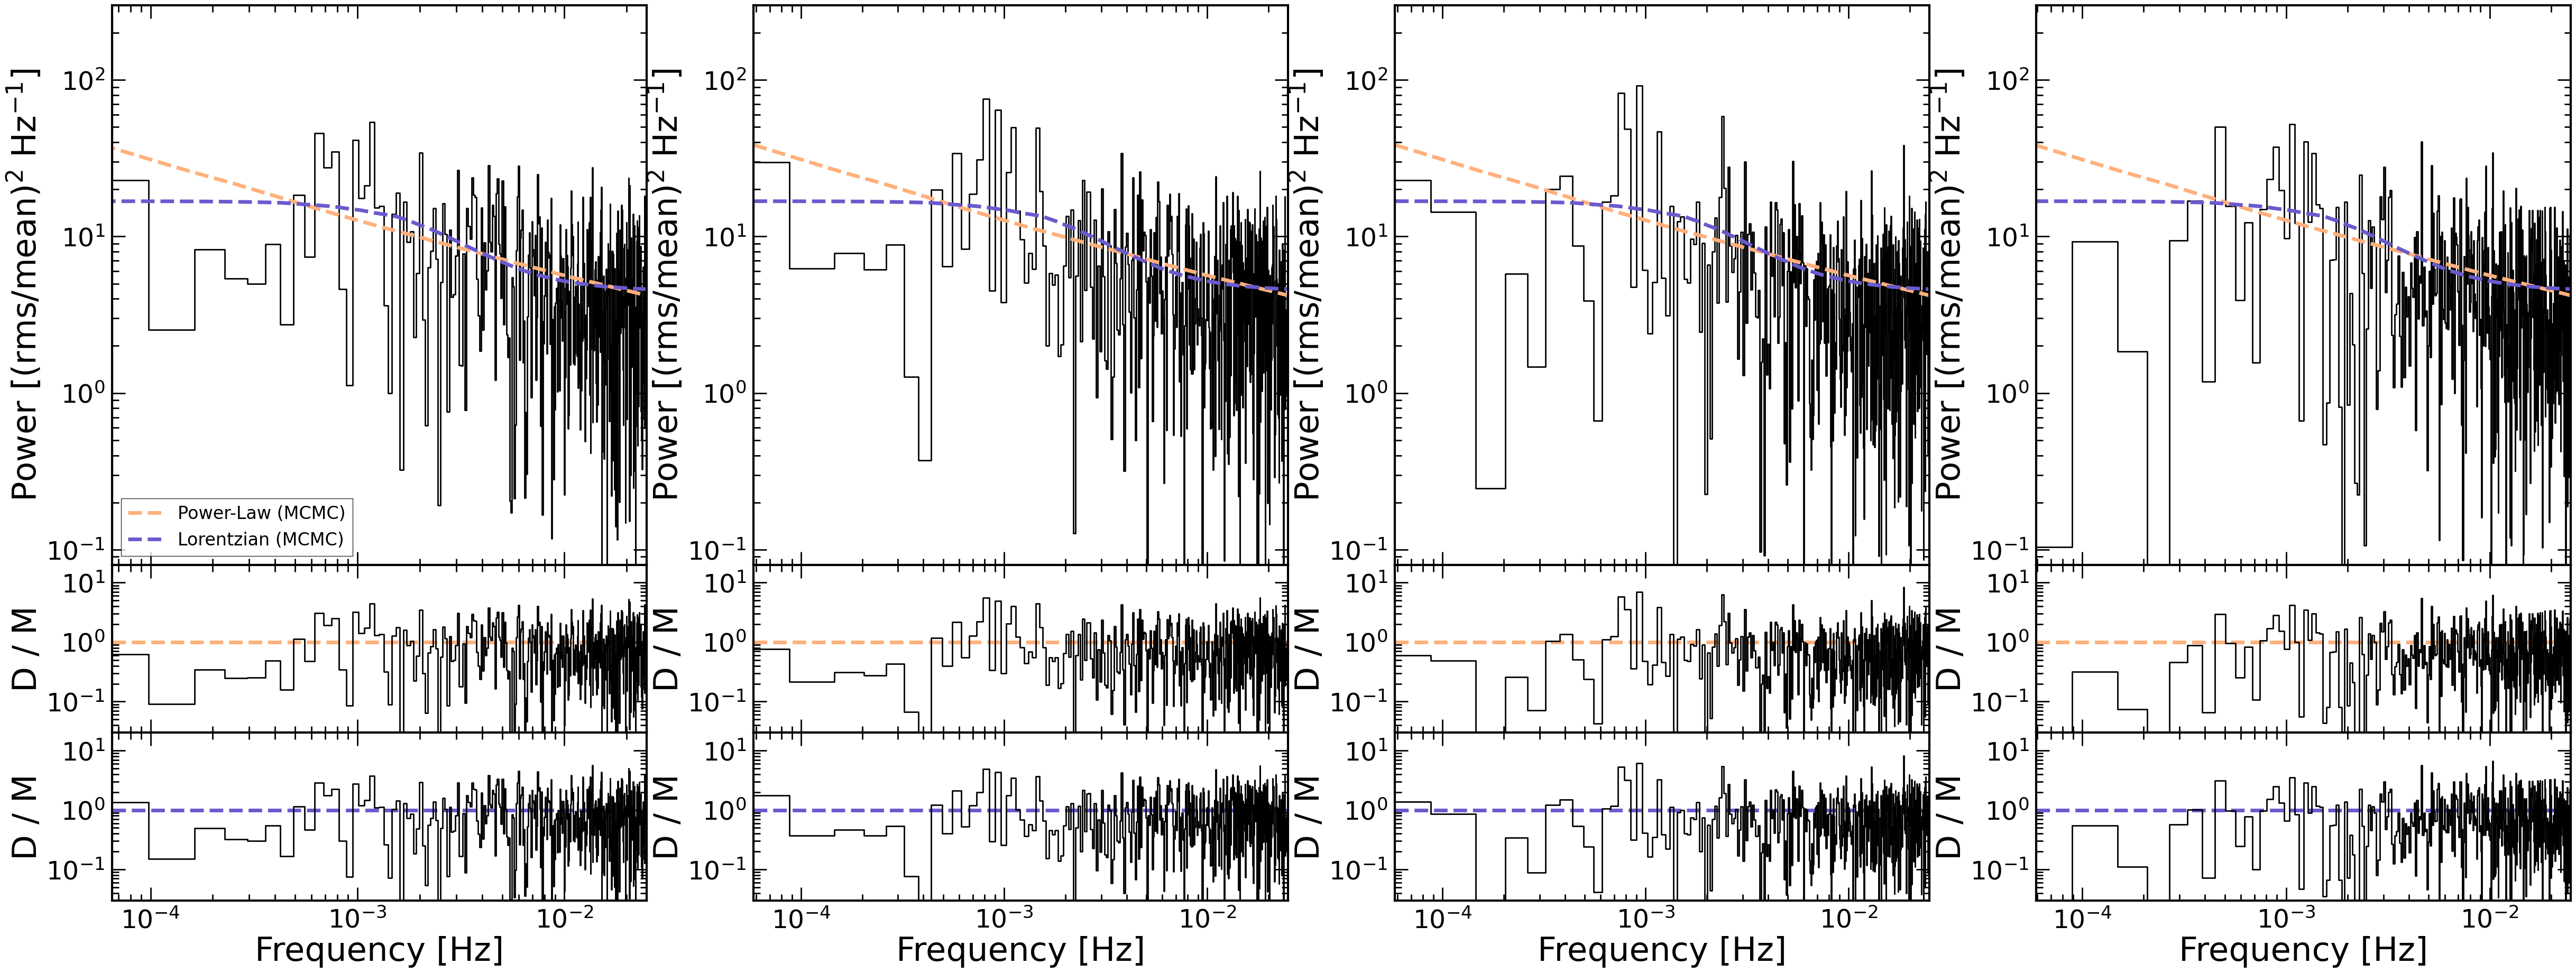

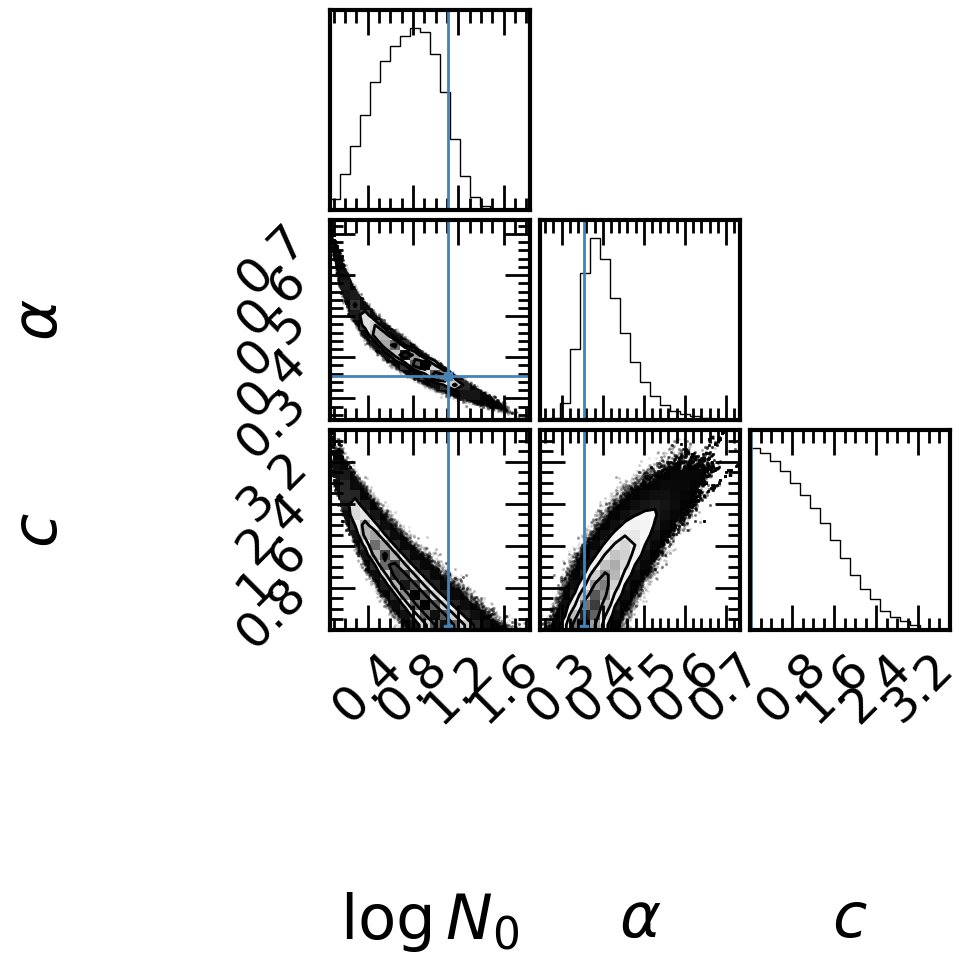

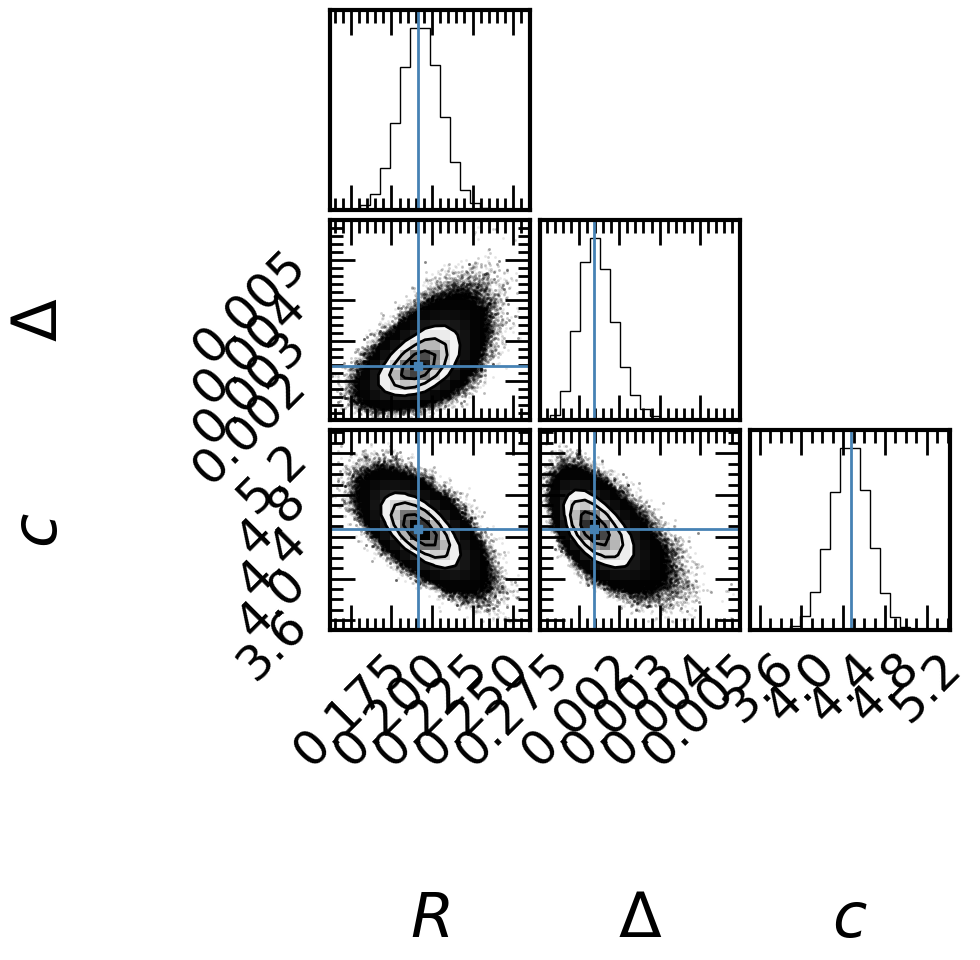

In [17]:
use_obs = np.array(['0902590201', '0902590301', '0902590401', '0902590501'])
Rhat_TK, Rhat, SSE_TK, SSE_comp = run_TK_sims_and_analysis_multi('Aug2022', use_obs, data_path, 2., 10., 20, n=0, n_sim=100, psd_model='powerlaw', maxlike_init=False)

In [18]:
print('Number of simulations run: ', len(SSE_TK))
# print('Rhat false detection number: ', len(np.where(Rhat_TK > Rhat)[0]))
print('SSE false detection number: ', len(np.where(SSE_TK > SSE_comp)[0]))

Number of simulations run:  100
SSE false detection number:  49


#### 2-10 keV, Lorentzian broadband model

R (power-law):  [10.778506618545537, 11.219905087161804, 16.626687195097826, 12.274385749805928]
QPO freq. (power-law):  [0.013642297650130548, 0.018144690781796965, 0.018648018648018648, 0.010344827586206896]
SSE (power-law):  1654.4854725313887
R (lorentzian):  [11.224602665951693, 11.059248430556748, 16.287500011118084, 13.293035968025983]
QPO freq. (lorentzian):  [0.013642297650130548, 0.018144690781796965, 0.018648018648018648, 0.010344827586206896]
SSE (lorentzian):  1611.86440546537
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
Number of obs: 4
[16.856947403617696, 14.900653859692781, 11.327820440292935, 19.319106980592796] 1756.9149323369081
Number of obs: 4
[15.305240249937457, 12.015568061030343, 9.422742556544422, 11.662247416623464] 1619.3170417337546
[14.562722021839448, 11.585957787735406, 12.93781384121846, 15.8335571445866] 1660.5887131842546
Number of obs: 4
Number of obs: 4
[12.67502144407182, 11

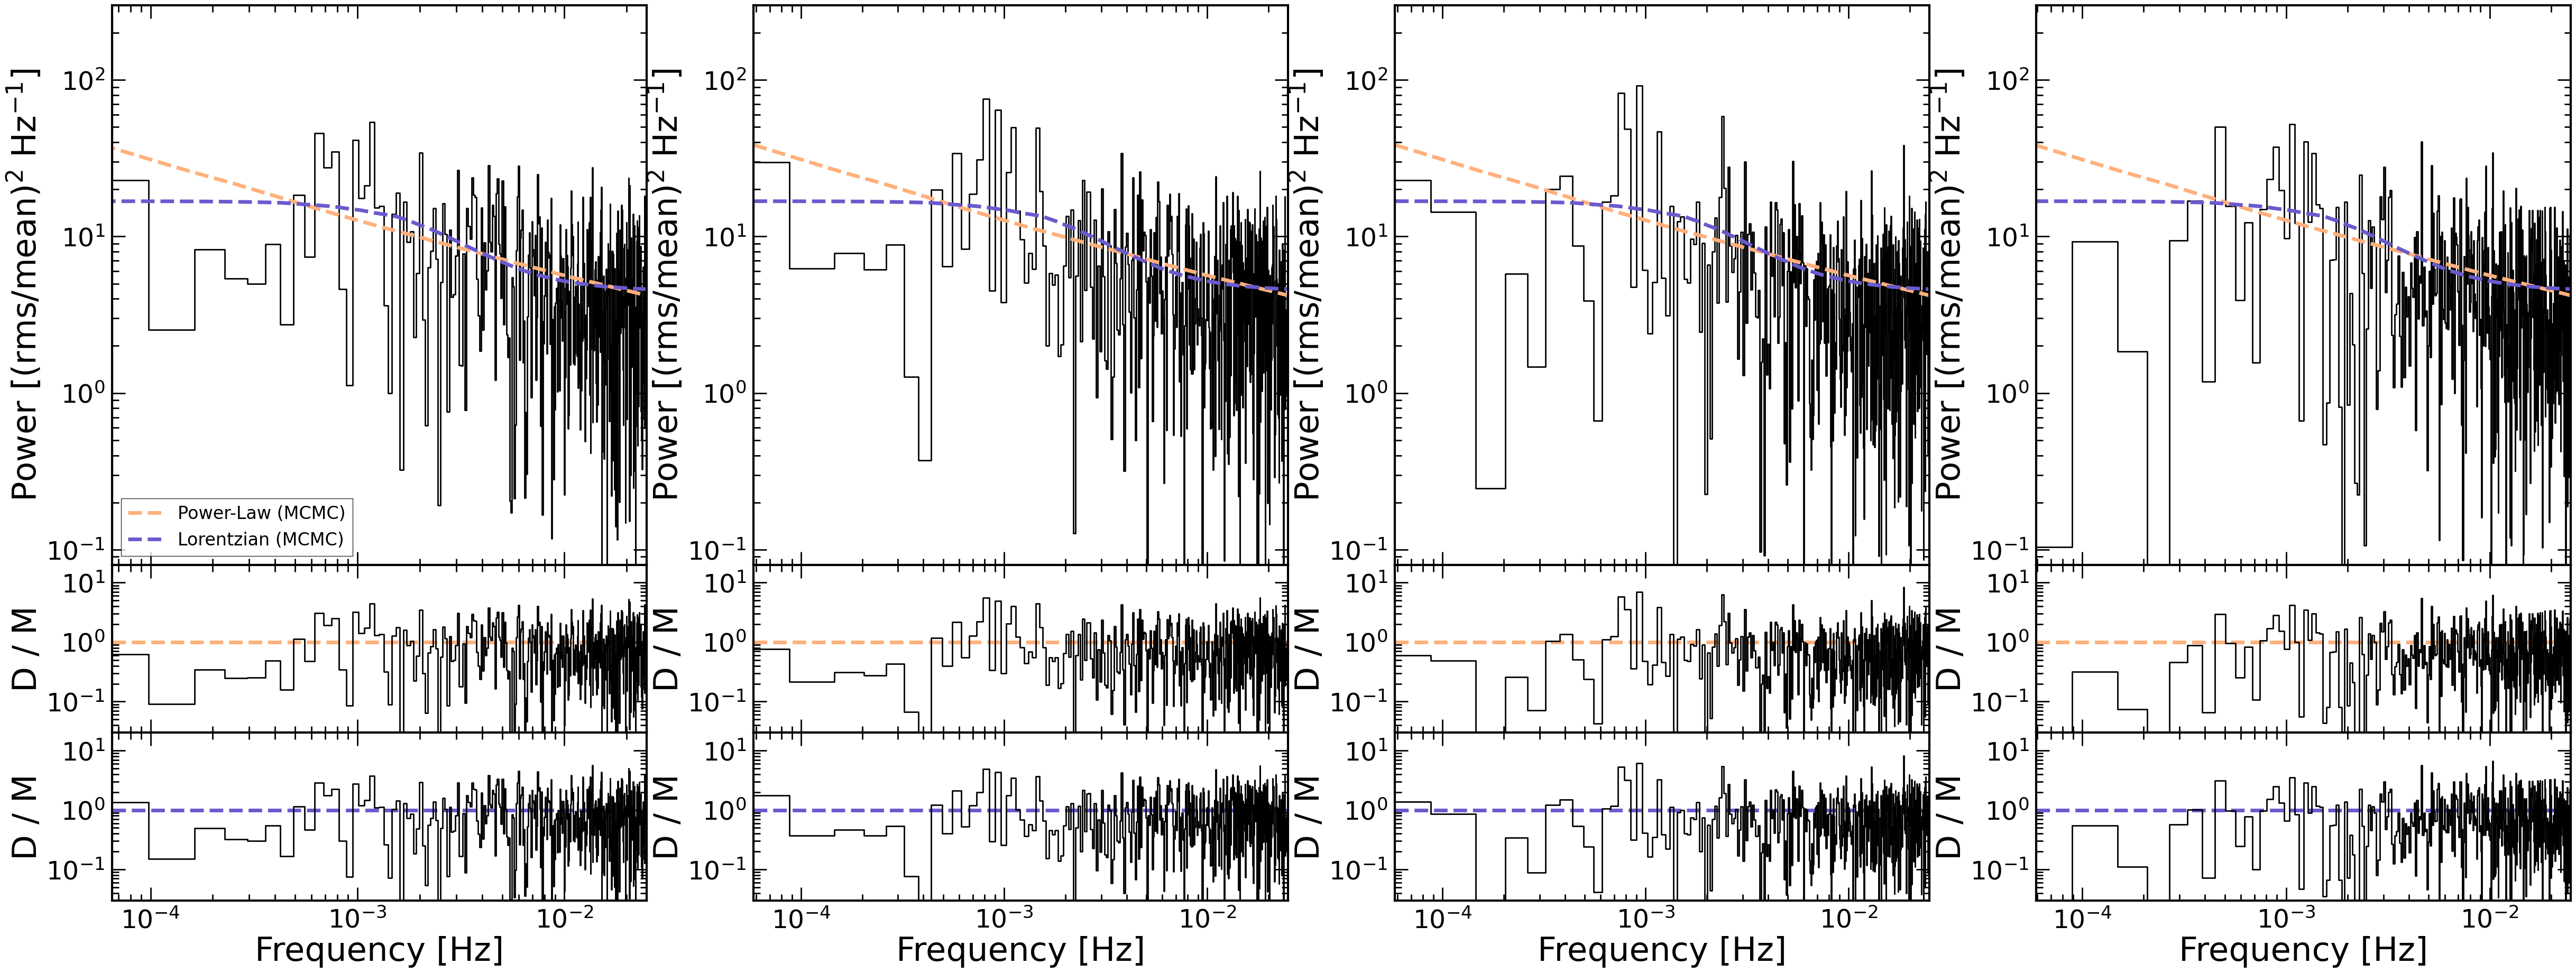

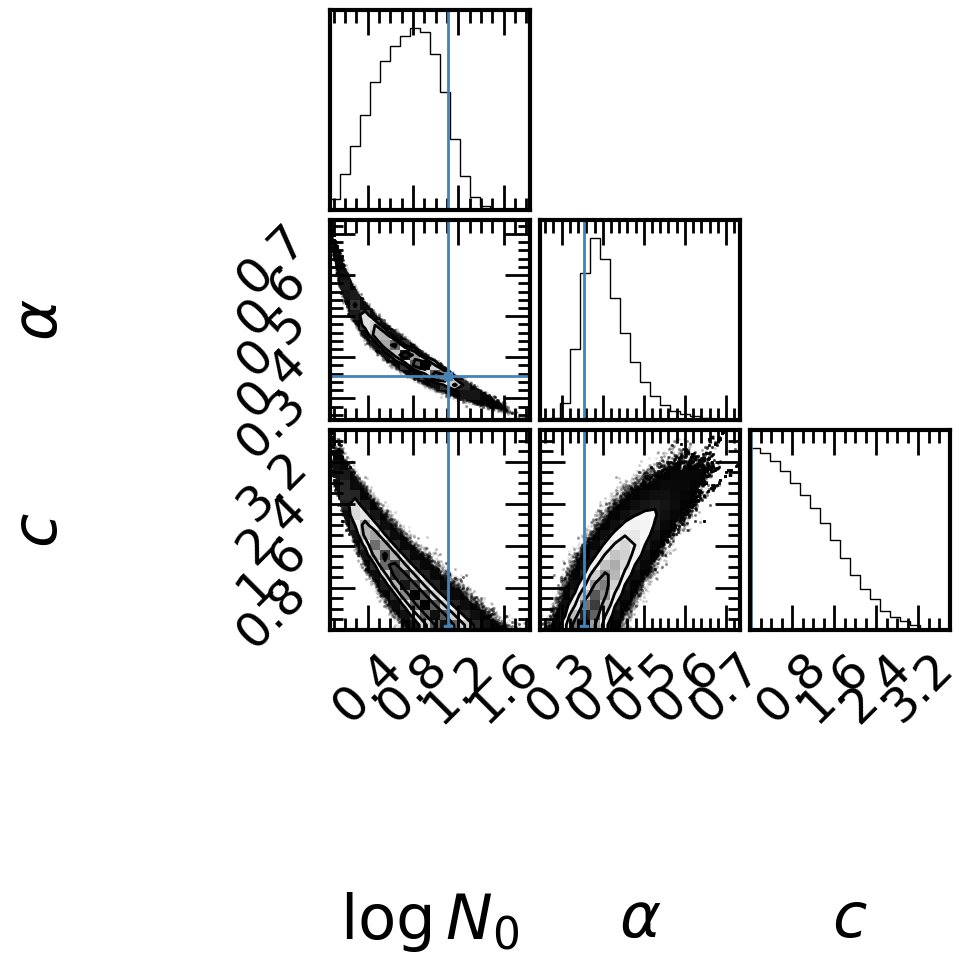

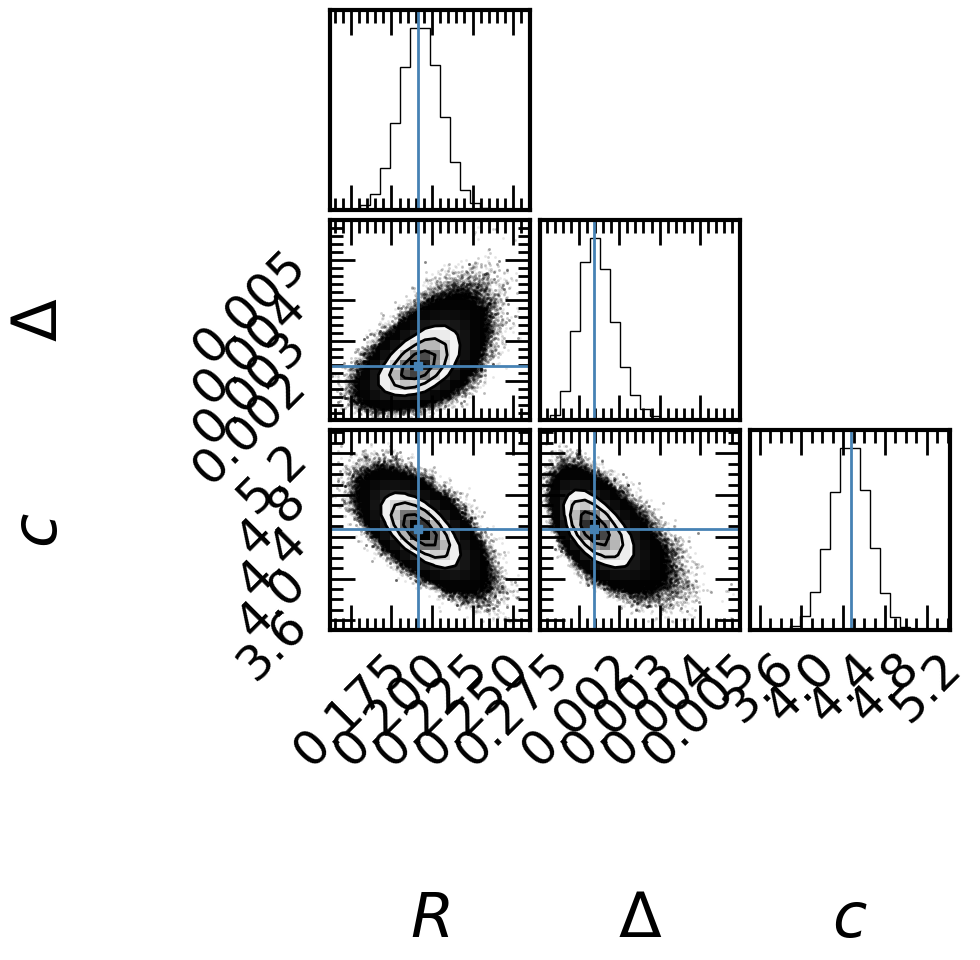

In [19]:
use_obs = np.array(['0902590201', '0902590301', '0902590401', '0902590501'])
Rhat_TK, Rhat, SSE_TK, SSE_comp = run_TK_sims_and_analysis_multi('Aug2022', use_obs, data_path, 2., 10., 20, n=0, n_sim=100, psd_model='lorentzian', maxlike_init=True)

In [20]:
print('Number of simulations run: ', len(SSE_TK))
# print('Rhat false detection number: ', len(np.where(Rhat_TK > Rhat)[0]))
print('SSE false detection number: ', len(np.where(SSE_TK > SSE_comp)[0]))

Number of simulations run:  100
SSE false detection number:  68
